In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
sns.set_style("darkgrid")
mpl.rcParams['figure.figsize'] = (20,5)

In [2]:
accidents_df = pd.read_csv('US_Accidents_Dec20_updated 2.csv')
accidents_df['Start_Date'] = pd.to_datetime(accidents_df['Start_Time'])
accidents_df['End_Date'] = pd.to_datetime(accidents_df['End_Time'])
accidents_df['Month'] = accidents_df['Start_Date'].dt.month
accidents_df['Year'] = accidents_df['Start_Date'].dt.year
accidents_df['Month_year'] = pd.to_datetime(accidents_df[['Year', 'Month']].assign(Day=1))

accidents_df['diff_minutes'] = accidents_df['End_Date'] - accidents_df['Start_Date']
accidents_df['diff_minutes']=accidents_df['diff_minutes']/np.timedelta64(1,'m')


In [74]:
accidents_df.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Start_Date', 'End_Date', 'Month', 'Year',
       'Month_year', 'diff_minutes'],
      dtype='object')

# A closer look into the # of accidents over the years per severity

Severity
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
Name: count, dtype: object

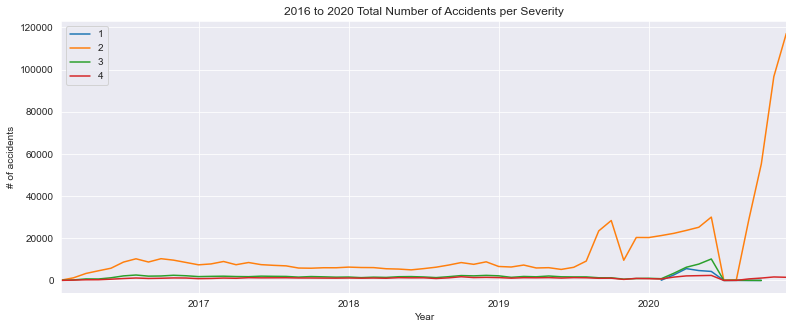

In [175]:
fig, ax = plt.subplots(figsize = (13,5))
weather_yr_avg.groupby('Severity')['count'].plot(ax = ax, ylabel = '# of accidents', xlabel = 'Year',title = "2016 to 2020 Total Number of Accidents per Severity",legend=True)

We see a spike in accidents (severity =2) starting mid 2019. Then starting 2020, we see an unusual increase in accidents with a dip in June and July. 

Severity
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
Name: count, dtype: object

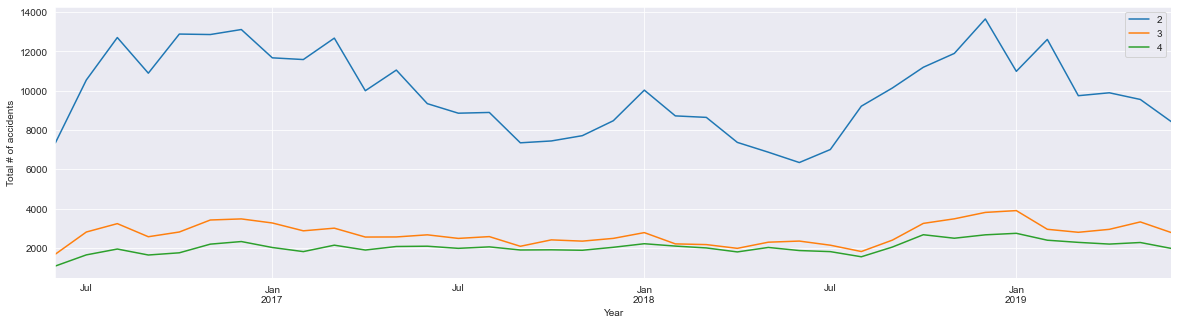

In [8]:
filter_year = accidents_df[ (accidents_df.Month_year >= '2016-06-01') & (accidents_df.Month_year <= '2019-06-01')]
filter_year[['Month','Year','Month_year','Severity', 'ID','Start_Date','End_Date']]

test = filter_year.groupby(['Month_year','Severity']).agg(count = ("ID","count"))
accident_count = test.reset_index()
accident_count
fig, ax = plt.subplots()
accident_yr = accident_count.set_index('Month_year')
accident_yr.groupby('Severity')['count'].plot(ax = ax, ylabel = 'Total # of accidents', xlabel = 'Year', legend=True)

In the plot from 2016 to 2020, there seems to be a huge jump in number of accidents, lets take a closer look from June 2016 to June 2019. In this graph, we can see we have more level 2 Severity accidents, peaking every january. As we discovered that lower temperatures impact the accident. 

# Does weather conditions have an impact on severity of an accident?

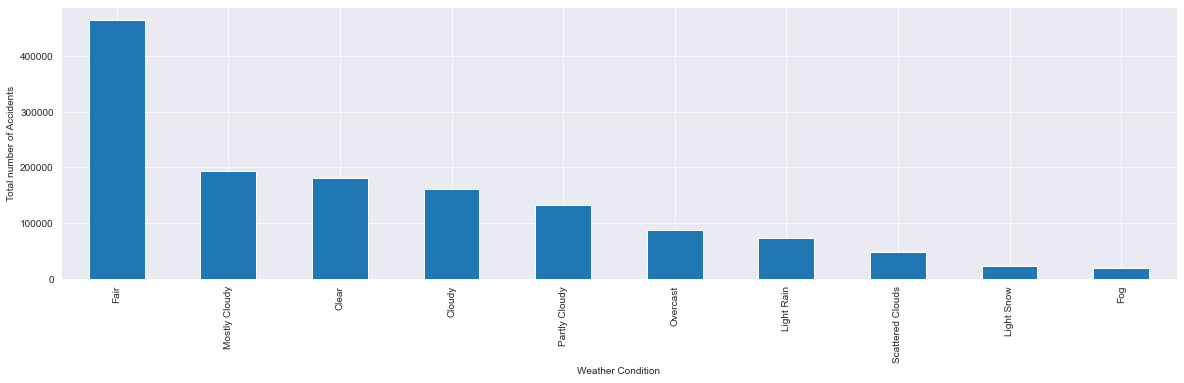

In [141]:
condition = accidents_df.groupby(["Weather_Condition"]).agg(count = ("ID","count"))
top12cond = condition["count"].nlargest(n = 10)
top12cond.plot(kind = "bar", stacked = True)
plt.xlabel("Weather Condition")
plt.ylabel("Total number of Accidents")
plt.show()

Text(0, 0.5, 'Total Number of Accidents')

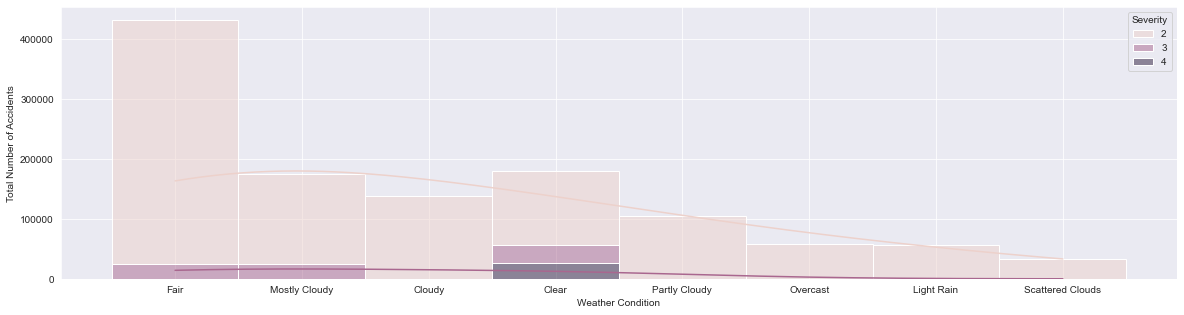

In [167]:
condition_sev = accidents_df.groupby(['Weather_Condition', 'Severity']).agg(count = ("ID","count"))
cond_sev_total = condition_sev.reset_index()

w = sns.histplot(
    data=cond_sev_total.sort_values('count', ascending = False).head(12),
    x='Weather_Condition',
    weights='count',
    hue='Severity',
    multiple='stack',
    kde = True
)
w.set_xlabel("Weather Condition")
w.set_ylabel("Total Number of Accidents")

Most accidents are level 2 severity as most accidents happen in Fair weather condition.
While most level 4 severity accidents happen on a clear day. 

In [4]:
severity = accidents_df.groupby(['Severity']).agg(accidents = ("ID","count"),
                                                Avg. Dist = ("Distance(mi)","mean"),
                                                temp_avg = ("Temperature(F)","mean"),
                                                wind_temp_avg = ("Wind_Chill(F)","mean"),
                                                humidity_avg = ("Humidity(%)","mean"),
                                                pressure_avg =("Pressure(in)","mean"),
                                               visibility_avg = ("Visibility(mi)","mean"), 
                                                wind_mph_avg = ("Wind_Speed(mph)", "mean"),
                                                precipitation_avg = ("Precipitation(in)","mean"))
severity

,count,dist_avg,temp_avg,wind_temp_avg,humidity_avg,pressure_avg,visibility_avg,wind_mph_avg,precipitation_avg
Severity,,,,,,,,,
1,28178,0.201586,71.030430,70.694230,49.954483,28.994273,9.526448,8.404521,0.005355
2,1212382,0.504544,59.131172,55.052538,64.798827,29.551848,9.096329,7.381547,0.007567
3,161052,0.606261,61.840944,54.569504,64.124144,29.576109,9.349319,9.014196,0.017849
4,114452,1.531702,58.316400,49.604656,67.625910,29.697658,9.100513,8.244479,0.010970


I wanted a show a general data grouping the Severity against the numerical data, specially, the average weather climate. 
Shown in the table, temperature decreasing, wind temperature decreasing, and humidity increasing seems to have a direct correlation with severity of an accident. Let's explore this data. 

/var/folders/9y/bwn856cd0_z4h_gyjb1b6hl80000gn/T/ipykernel_6894/2802019673.py:14: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = weather_df [ ((weather_df < lower_limit) | ((weather_df > upper_limit))).any(axis=1) ]
/var/folders/9y/bwn856cd0_z4h_gyjb1b6hl80000gn/T/ipykernel_6894/2802019673.py:17: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  no_outliers = weather_df [~((weather_df < lower_limit) | ((weather_df > upper_limit))).any(axis=1) ]


<AxesSubplot:>

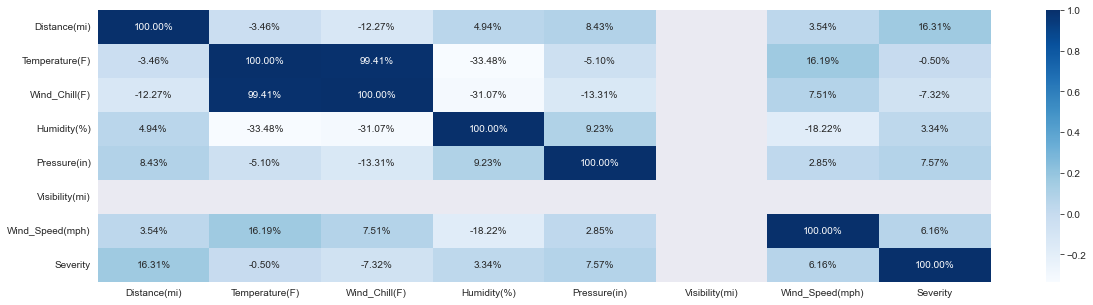

In [75]:
weather_df = accidents_df[['ID','Distance(mi)','Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Speed(mph)']]
merge_df = accidents_df[['ID','Severity','Month_year']]
merge_df.set_index('ID')

weather_df.set_index('ID')
q1 = weather_df.quantile(.25)
q3 = weather_df.quantile(.75)
iqr = q3-q1
lower_limit = q1 - 1.5*iqr
upper_limit = q3 + 1.5*iqr

outliers = weather_df [ ((weather_df < lower_limit) | ((weather_df > upper_limit))).any(axis=1) ]
# 443140 outliers
# 978079 non outliers
no_outliers = weather_df [~((weather_df < lower_limit) | ((weather_df > upper_limit))).any(axis=1) ]
weather_severity = no_outliers.merge(merge_df, on = 'ID', how = 'left')
no_out_weather_corr = weather_severity.corr(method= 'pearson')
sns.heatmap(no_out_weather_corr, cmap = 'Blues',annot = True, fmt=".2%")

With no outliers, in the data set, we kept about 1million data points to see the correlation. I wanted to see with no outliers, is there a correlation between severity and climate. 
Severity of an accident has the biggest correlation to Distance(mi) or the miles it pacted in road. 
Severity of an accident had a correlation with climate, such as Wind Chill Temp, Pressure(in), and wind Speed. 
Let's explore more on the data without Visibility since it has no impact. 

Severity
1    AxesSubplot(0.547727,0.391471;0.352273x0.222059)
2    AxesSubplot(0.547727,0.391471;0.352273x0.222059)
3    AxesSubplot(0.547727,0.391471;0.352273x0.222059)
4    AxesSubplot(0.547727,0.391471;0.352273x0.222059)
Name: wind_mph_avg, dtype: object

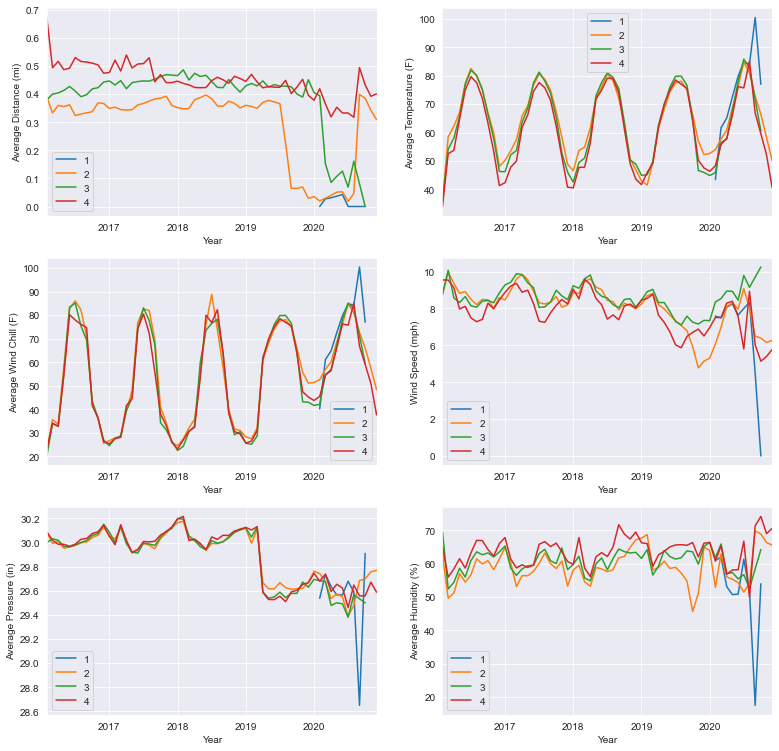

In [168]:
weather_sev_avg = weather_severity.groupby(['Month_year','Severity']).agg(count = ("ID","count"),
                                             dist_avg = ("Distance(mi)","mean"),
                                                temp_avg = ("Temperature(F)","mean"),
                                                wind_temp_avg = ("Wind_Chill(F)","mean"),
                                                humidity_avg = ("Humidity(%)","mean"),
                                                pressure_avg =("Pressure(in)","mean"), 
                                                wind_mph_avg = ("Wind_Speed(mph)", "mean"))
weather_yr = weather_sev_avg.reset_index()
fig, ax = plt.subplots(3,2, sharex =  False, sharey = False, figsize = (13,13))
weather_yr_avg = weather_yr.set_index('Month_year')
weather_yr_avg.groupby('Severity')['temp_avg'].plot(ax = ax[0,1], ylabel = 'Average Temperature (F)', xlabel = 'Year', legend=True)
weather_yr_avg.groupby('Severity')['dist_avg'].plot(ax = ax[0,0], ylabel = 'Average Distance (mi)',xlabel = 'Year', legend=True)
weather_yr_avg.groupby('Severity')['wind_temp_avg'].plot(ax = ax[1,0], ylabel = 'Average Wind Chill (F)', xlabel = 'Year',legend=True)
weather_yr_avg.groupby('Severity')['humidity_avg'].plot(ax = ax[2,1], ylabel = 'Average Humidity (%)', xlabel = 'Year',legend=True)
weather_yr_avg.groupby('Severity')['pressure_avg'].plot(ax = ax[2,0], ylabel = 'Average Pressure (in)',xlabel = 'Year', legend=True)
weather_yr_avg.groupby('Severity')['wind_mph_avg'].plot(ax = ax[1,1], ylabel = 'Wind Speed (mph)', xlabel = 'Year',legend=True)

Looking at the data, we can see the average climate in respect to Severity over time. 

# Does Infastructure prevent accidents?

/var/folders/9y/bwn856cd0_z4h_gyjb1b6hl80000gn/T/ipykernel_6894/410774257.py:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  t.set( xlabel = "Types of Infastructure", ylabel = "Severity of Accident", Title = "Total number of accidents")


[Text(0.5, 25.0, 'Types of Infastructure'),
 Text(160.0, 0.5, 'Severity of Accident'),
 Text(0.5, 1.0, 'Total number of accidents')]

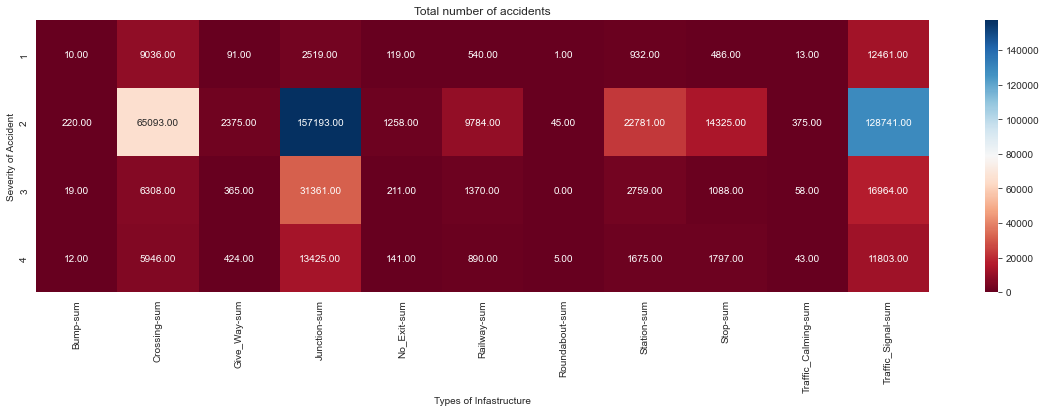

In [177]:
traffic = accidents_num_test*1
traffic_sev_total = traffic.groupby('Severity').agg(['sum'], axis = "columns")
t = sns.heatmap(traffic_sev_total, cmap = 'RdBu', annot = True, fmt=".2f")
t.set( xlabel = "Types of Infastructure", ylabel = "Severity of Accident", Title = "Total number of accidents")

<AxesSubplot:>

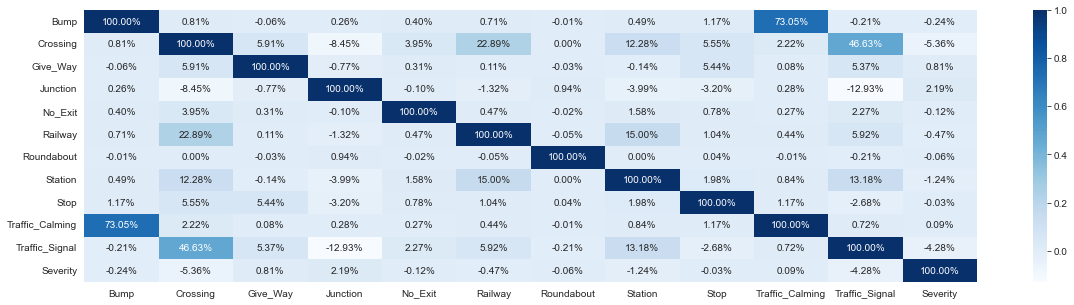

In [180]:
accidents_num_test = accidents_df[['Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal','Severity']]
accidents_num_test = accidents_num_test*1
accidents_num_cor = accidents_num_test.corr(method= 'pearson')
sns.heatmap(accidents_num_cor, cmap = 'Blues',annot = True, fmt=".2%")

Is there a correlation between infrastructre types and severity of the accident?
In this case, we can see that Crossing walks, Junctions, Traffic Signals have the biggest correlation to a car accidents.

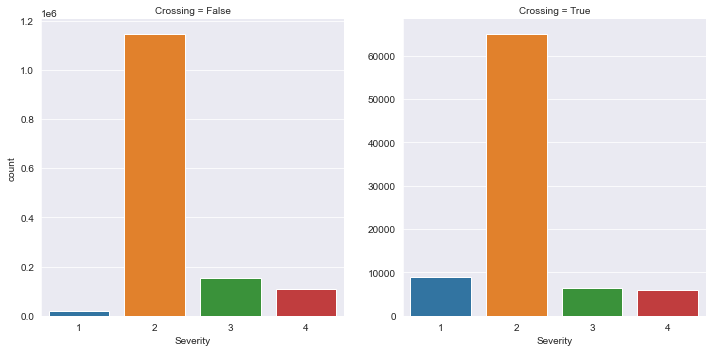

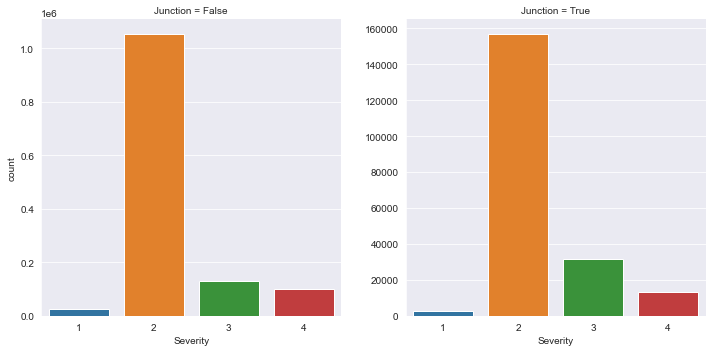

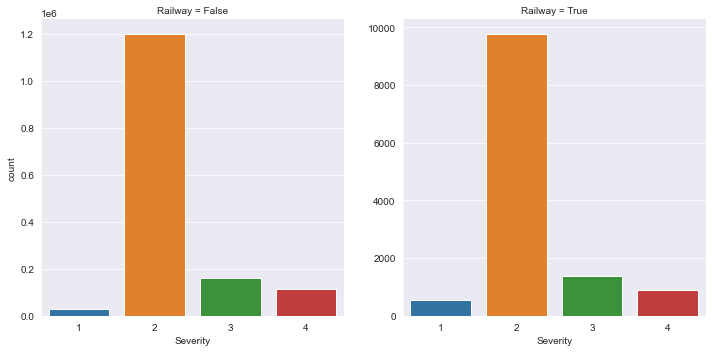

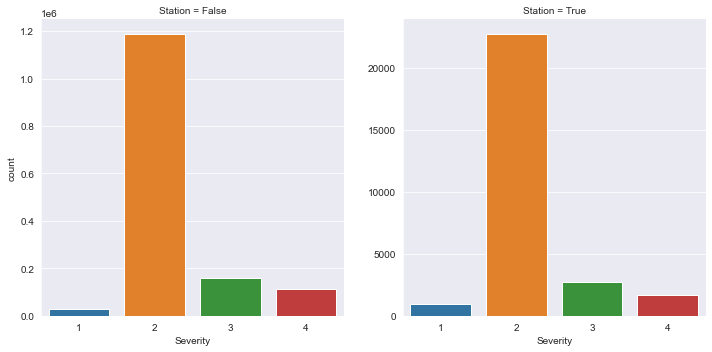

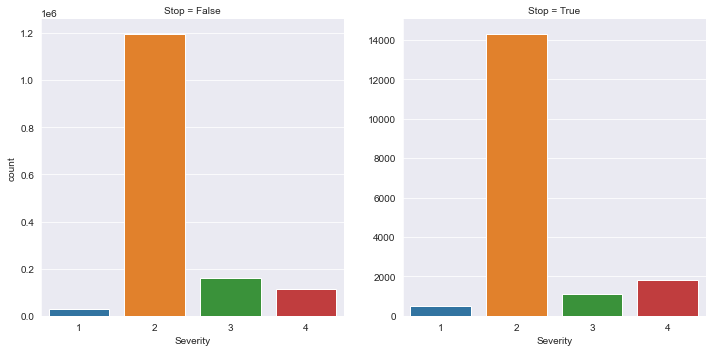

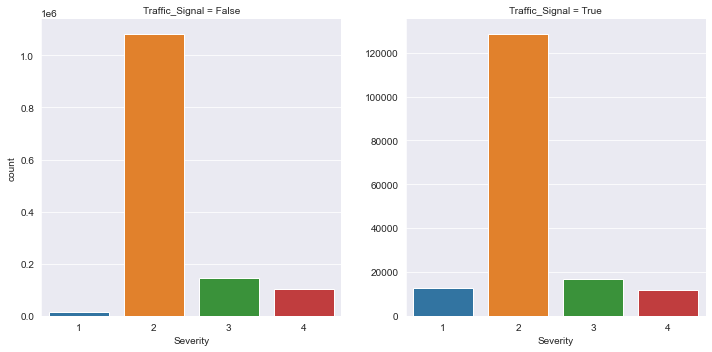

In [182]:
listofvariables = ['Crossing', 'Junction', 'Railway', 'Station', 'Stop', 'Traffic_Signal']
for f in listofvariables:
     sns.catplot(x="Severity", col=f, data=accidents_df, kind="count",sharey = False);

### Does Infrastruce delay traffic (in miles)?

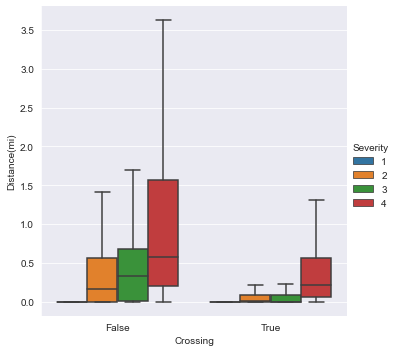

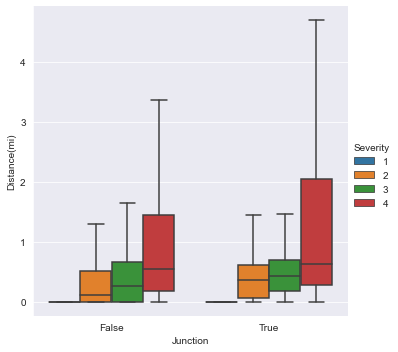

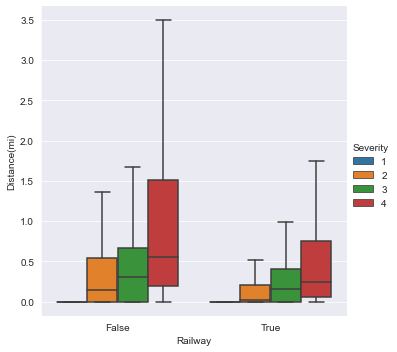

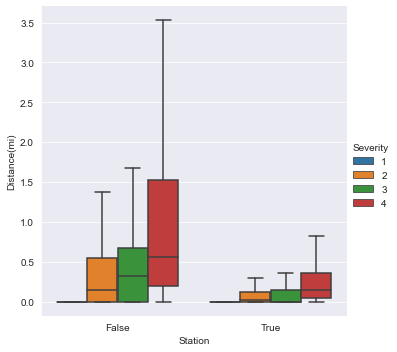

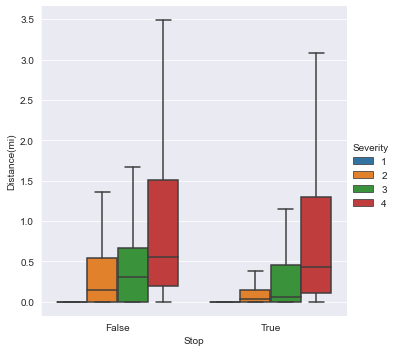

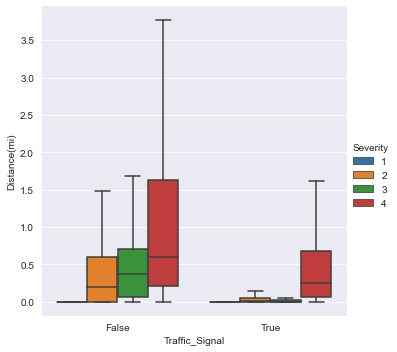

In [183]:
listofvariables = ['Crossing', 'Junction', 'Railway', 'Station', 'Stop', 'Traffic_Signal']
for t in listofvariables:
    sns.catplot(data = accidents_df, x = t, y = "Distance(mi)", kind = "box", sym = "Severity")

# How long do accidents take to resolve?

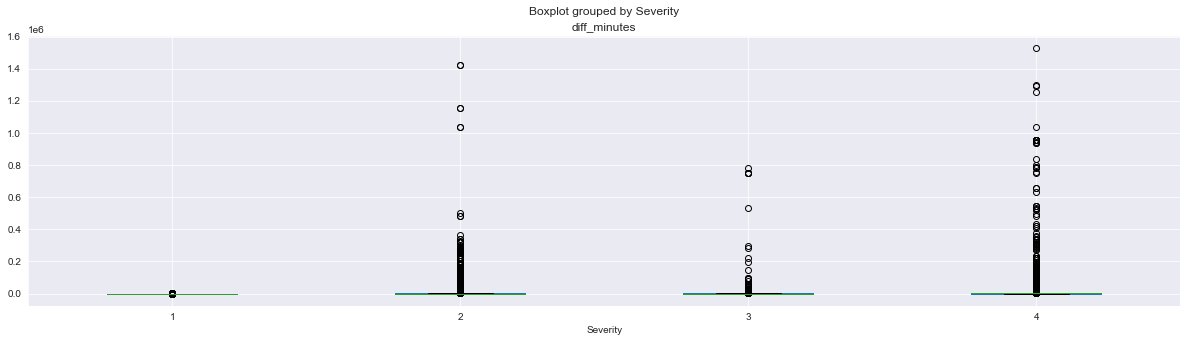

In [188]:

fix, ax = plt.subplots()
accidents_df.boxplot(column=['diff_minutes'], by='Severity', ax=ax)
plt.show()

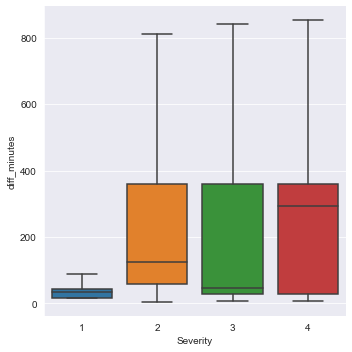

In [191]:
sns.catplot(data = accidents_df, x = 'Severity', y = "diff_minutes", kind = "box", sym = "")

/var/folders/9y/bwn856cd0_z4h_gyjb1b6hl80000gn/T/ipykernel_6894/3141217398.py:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_time_dist = time_dist [ ((time_dist < lower_limit) | ((time_dist > upper_limit))).any(axis=1) ]
/var/folders/9y/bwn856cd0_z4h_gyjb1b6hl80000gn/T/ipykernel_6894/3141217398.py:13: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  no_outliers_time_dist = time_dist [~((time_dist < lower_limit) | ((time_dist > upper_limit))).any(axis=1) ]


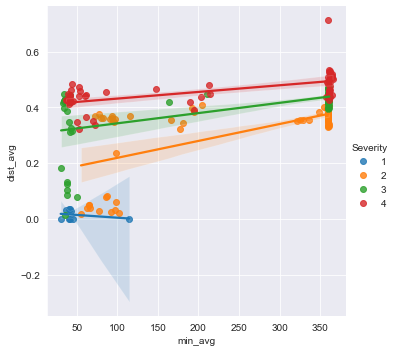

In [192]:
time_dist = accidents_df[['diff_minutes','Distance(mi)','ID']]
time_dist_df = time_dist.set_index('ID')
time_merge_df = accidents_df[['ID','Severity','Month_year']]

q1 = time_dist.quantile(.25)
q3 = time_dist.quantile(.75)
iqr = q3-q1
lower_limit = q1 - 1.5*iqr
upper_limit = q3 + 1.5*iqr

outliers_time_dist = time_dist [ ((time_dist < lower_limit) | ((time_dist > upper_limit))).any(axis=1) ]

no_outliers_time_dist = time_dist [~((time_dist < lower_limit) | ((time_dist > upper_limit))).any(axis=1) ]
no_outliers_time_dist

time_dist_sev_df = no_outliers_time_dist.merge(time_merge_df, on = 'ID', how = 'left')
time_mi_avg = time_dist_sev_df.groupby(['Month_year','Severity']).agg(count = ("ID","count"),
                                             dist_avg = ("Distance(mi)","mean"),
                                                min_avg = ("diff_minutes","mean"))
time_mi_df = time_mi_avg.reset_index()
time_mi_df
sns.lmplot(x="min_avg", y="dist_avg", hue = "Severity", data= time_mi_df);

As severity of accident increases, so does the average traffic distance (mi) it impacts and average time (minutes) to resolve

In [19]:
weather_severity
reg_model = weather_severity.dropna()
independent_variable = reg_model.iloc[:, 1:7]
dependent_variable = reg_model.iloc[:, -2]

independent_variable = sm.add_constant(independent_variable)  

regression_model_std = sm.OLS(dependent_variable,independent_variable).fit() 
regression_model_std.summary()

/Users/nominbatbayar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Severity   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     4457.
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:48:11   Log-Likelihood:            -5.0222e+05
No. Observations:              665722   AIC:                         1.004e+06
Df Residuals:                  665716   BIC:                         1.005e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Distance(mi)       0.1892      0.002    101.090      0.000       0.185       0.193
Temperature(F)     0.0293      0.000     85.386      0.000       0.029       0.030
Wind_Chill(F)     -0.0276      0.000    -89.890      0.000      -0.028      -0.027
Humidity(%)        0.0006    3.2e-05     19.425      0.000       0.001       0.001
Pressure(in)      -0.0056      0.001     -3.756      0.000      -0.008      -0.003
Visibility(mi)     0.2094      0.004     47.289      0.000       0.201       0.218
==============================================================================
Omnibus:                   283979.210   Durbin-Watson:                   1.307
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1287757.151
Skew:                           2.099   Prob(JB):                         0.00
Kurtosis:                       8.366   Cond. No.                         817.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""